In [6]:
import napari
import numpy as np
import skimage
import pandas as pd
import timeit
import os
import ot
import matplotlib.pyplot as plot
from scipy.sparse import csr_matrix

# Define the directory where your image series is stored
path = '/Users/andrewrodriguez/Desktop/Files/OT_Testing/sample_data.csv'
df = pd.read_csv(path)

viewer = napari.Viewer()
napari.run()

In [7]:
if 'plate' in viewer.layers:
    viewer.layers.remove('plate')
plate_coords = [[-2, -2], [2, -2],[2, 2], [-2, 2]]
viewer.add_shapes(plate_coords, face_color = "white", opacity = 1, edge_color="white", edge_width=0)

<Shapes layer 'plate_coords' at 0x15635e390>

In [8]:

# Function to generate a random color
def get_color(val):
    if val == 0:
        c = "#FF0000"
    elif val == 1:
        c = "#0000FF"
    elif val == 2:
        c = "#FFA500"
    else:
        c = "#FFC0CB"
    return c

# Check if 'cells' layer exists and remove it
if 'cells' in viewer.layers:
    viewer.layers.remove('cells')

# Extract initial cell coordinates
init_cell_coords = df.loc[:, ['t_ind', 'y', 'x']].to_numpy()

# Extract ground truth values
ground_truth_values = df.loc[:, "ground_truth"].to_numpy()

# Get unique ground truth values and assign a unique color to each
unique_values = np.unique(ground_truth_values)
color_map = {val: get_color(val) for val in unique_values}

# Map the ground truth values to their corresponding colors
colors = [color_map[val] for val in ground_truth_values]

# Add points to the viewer with colors based on ground truth values
viewer.add_points(
    init_cell_coords,
    ndim=3,
    name='cells',
    face_color=colors,
    edge_color="black",
    edge_width=0.1,
    edge_width_is_relative=True,
    opacity=1,
    size=0.01,
    visible=True
)

<Points layer 'cells' at 0x30cc12150>

In [9]:
# CONSTANTS

MAP_DIM = 150
WELL_DIM = 2
SIGMA_PIX = 2
SCALE = (WELL_DIM/MAP_DIM, WELL_DIM/MAP_DIM)
TRANSLATE =(-0.5 * WELL_DIM + (0.015/WELL_DIM), -0.5 * WELL_DIM + (0.015)/ WELL_DIM)

times = df["t_ind"].unique().tolist()

points = []
ids = []
c = 0

for x in range(MAP_DIM):
    for y in range(MAP_DIM):
        points.append([x,y])
        ids.append(c)
        c+=1

ids = np.array(ids)
points = np.array(points)
print("Building Cost Matrix")
C = ot.dist(points, points)
C = C.astype(np.int16)

# fig, axes = plot.subplots(1, 2, figsize=(12, 6))

# # Display the first image in the first subplot
# axes[0].imshow(C)
# axes[0].set_title('Cost Matrix')

# # Display the second image in the second subplot
# axes[1].imshow(ids.reshape(MAP_DIM, MAP_DIM))
# axes[1].set_title('IDs for Each Pixel')

# # Remove axis for a cleaner look
# for ax in axes:
#     ax.axis('on')

# plot.show()

Building Cost Matrix


In [10]:

memory_usage = C.nbytes

print(f"Memory usage of the array: {memory_usage/1E9} gigabytes")

Memory usage of the array: 1.0125 gigabytes


In [11]:
translated_df = df[["x", "y", "t_ind", "ground_truth", "in_scan"]].copy()
translated_df["x"] = (translated_df["x"] + WELL_DIM/2) * (MAP_DIM/WELL_DIM)
translated_df["y"] = (translated_df["y"] + WELL_DIM/2) * (MAP_DIM/WELL_DIM)
translated_df.head()

,x,y,t_ind,ground_truth,in_scan
0,75.234137,75.062181,0,0,False
1,76.176359,74.796219,0,0,False
2,74.830287,73.560065,0,0,False
3,76.933706,73.827971,0,0,False
4,74.463800,73.770231,0,0,False


In [12]:
import concurrent.futures
import numpy as np
import pandas as pd
import skimage.filters
from scipy.sparse import csr_matrix
import ot


def process_time_step(i):
    later_time = i + 1
    earlier_time = i

    later_df = translated_df[(translated_df["t_ind"] == later_time)]
    earlier_df = translated_df[(translated_df["t_ind"] == earlier_time) & (translated_df["in_scan"] == False)]

    later_coords = np.int64(later_df[['x', 'y']].values)
    earlier_coords = np.int64(earlier_df[['x', 'y']].values)

    later_n_cells = later_coords.shape[0]
    earlier_n_cells = earlier_coords.shape[0]

    later_map = np.zeros((MAP_DIM, MAP_DIM))
    earlier_map = np.zeros((MAP_DIM, MAP_DIM))

    later_prop = np.ones(later_n_cells)
    earlier_prop = np.ones(earlier_n_cells)

    for idx in range(later_n_cells):
        later_map[later_coords[idx, 1], later_coords[idx, 0]] += later_prop[idx]

    for idx in range(earlier_n_cells):
        earlier_map[earlier_coords[idx, 1], earlier_coords[idx, 0]] += earlier_prop[idx]

    later_map = skimage.filters.gaussian(later_map, sigma=SIGMA_PIX, truncate=1)
    earlier_map = skimage.filters.gaussian(earlier_map, sigma=SIGMA_PIX, truncate=1)

    scaling = sum(sum(later_map)) / sum(sum(earlier_map)) 

    later_flat_map = later_map.flatten()
    earlier_flat_map = earlier_map.flatten() * scaling

    emd = ot.emd(later_flat_map, earlier_flat_map, C)

    sparse_output = csr_matrix(emd)
    
    print(f"ot {i} ran")

    return i, sparse_output

sk = [None] * (len(times) - 1)
with concurrent.futures.ThreadPoolExecutor(max_workers=2) as executor:
    futures = {executor.submit(process_time_step, i): i for i in range(len(times) - 1)}
    for future in concurrent.futures.as_completed(futures):
        i, result = future.result()
        sk[i] = result

ot 2 ran
ot 1 ran
ot 0 ran
ot 3 ran
ot 5 ran
ot 6 ran
ot 4 ran
ot 7 ran
ot 9 ran
ot 8 ran
ot 10 ran
ot 11 ran
ot 15 ran
ot 14 ran
ot 12 ran
ot 13 ran
ot 16 ran
ot 18 ran
ot 19 ran
ot 17 ran
ot 23 ran
ot 20 ran
ot 21 ran
ot 22 ran
ot 24 ran
ot 27 ran
ot 26 ran
ot 25 ran
ot 28 ran
ot 29 ran


In [13]:
csr = sk[-1]

# Check the memory usage of the CSR matrix
data_memory = csr.data.nbytes
indices_memory = csr.indices.nbytes
indptr_memory = csr.indptr.nbytes
total_memory = data_memory + indices_memory + indptr_memory

print(f"Memory usage of the data array: {data_memory} bytes")
print(f"Memory usage of the indices array: {indices_memory} bytes")
print(f"Memory usage of the indptr array: {indptr_memory} bytes")
print(f"Total memory usage of the CSR matrix: {total_memory} bytes")

Memory usage of the data array: 16880 bytes
Memory usage of the indices array: 8440 bytes
Memory usage of the indptr array: 90004 bytes
Total memory usage of the CSR matrix: 115324 bytes


In [14]:

def percentage_non_zero(matrix):
    matrix = np.array(matrix)
    total_elements = matrix.size
    non_zero_elements = np.count_nonzero(matrix)
    percentage = (non_zero_elements / total_elements) * 100
    return percentage

matrix = sk[-1].toarray()
result = percentage_non_zero(matrix)
print(f"Percentage of non-zero values: {result:.4f}%")

Percentage of non-zero values: 0.0004%


In [15]:
chains = []
gens_back = len(sk) - 1
parent_matrix = sk[len(sk) - 1]

for i in range(gens_back):
    start_time = timeit.default_timer()
    chains.append(parent_matrix.toarray())
    child_matrix = sk[len(sk) - (i + 2)]

    parent_matrix = parent_matrix.dot(child_matrix)


    end_time = timeit.default_timer()
    runtime = end_time - start_time
    print(f"Runtime for mat mul number {i}: {runtime:.4f} seconds")

chains.append(parent_matrix.toarray())

Runtime for mat mul number 0: 0.0064 seconds
Runtime for mat mul number 1: 0.0018 seconds
Runtime for mat mul number 2: 0.0025 seconds
Runtime for mat mul number 3: 0.0015 seconds
Runtime for mat mul number 4: 0.0016 seconds
Runtime for mat mul number 5: 0.0019 seconds
Runtime for mat mul number 6: 0.0018 seconds
Runtime for mat mul number 7: 0.0015 seconds
Runtime for mat mul number 8: 0.0018 seconds
Runtime for mat mul number 9: 0.0017 seconds
Runtime for mat mul number 10: 0.0019 seconds
Runtime for mat mul number 11: 0.0018 seconds
Runtime for mat mul number 12: 0.0017 seconds
Runtime for mat mul number 13: 0.0018 seconds
Runtime for mat mul number 14: 0.0024 seconds
Runtime for mat mul number 15: 0.0023 seconds
Runtime for mat mul number 16: 0.0018 seconds
Runtime for mat mul number 17: 0.0018 seconds
Runtime for mat mul number 18: 0.0017 seconds
Runtime for mat mul number 19: 0.0018 seconds
Runtime for mat mul number 20: 0.0015 seconds
Runtime for mat mul number 21: 0.0015 second

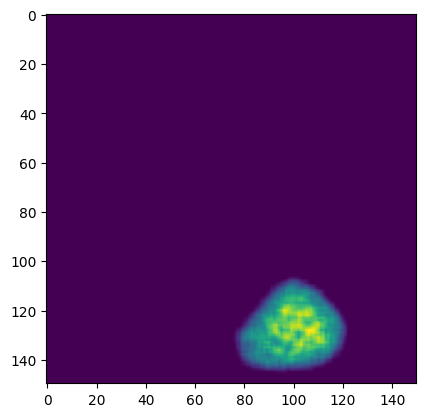

In [16]:
selected_cells = translated_df[(translated_df["ground_truth"] == 3) & (translated_df["t_ind"] == max(times))]
selected_coords = selected_cells[['x', 'y']].values

time_maps = []
selected_map = np.zeros((MAP_DIM, MAP_DIM))
cell_coords = np.int64(selected_coords)
current_cells = cell_coords
n_cells = current_cells.shape[0]
prop = np.ones(n_cells)  

for idx in range(n_cells):
    selected_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]

selected_map = skimage.filters.gaussian(selected_map, sigma=SIGMA_PIX, truncate=1)
plot.imshow(selected_map)

In [17]:
flat_sel_map = selected_map.flatten()
selected_pix = []

for i in range(len(flat_sel_map)):
   if flat_sel_map[i] > 0:
       selected_pix.append(i)

cleaned_chains = []

for chain in chains:
   clean = []
   for pix in selected_pix:
       clean.append(chain[pix])
   cleaned_chains.append(clean)

summed_chains = []

for chain in cleaned_chains:
   sc = np.array(chain).sum(axis = 0)
   sc = sc.reshape(MAP_DIM,MAP_DIM)
   summed_chains.append(sc)

summed_chains.reverse()
summed_chains.append(selected_map)

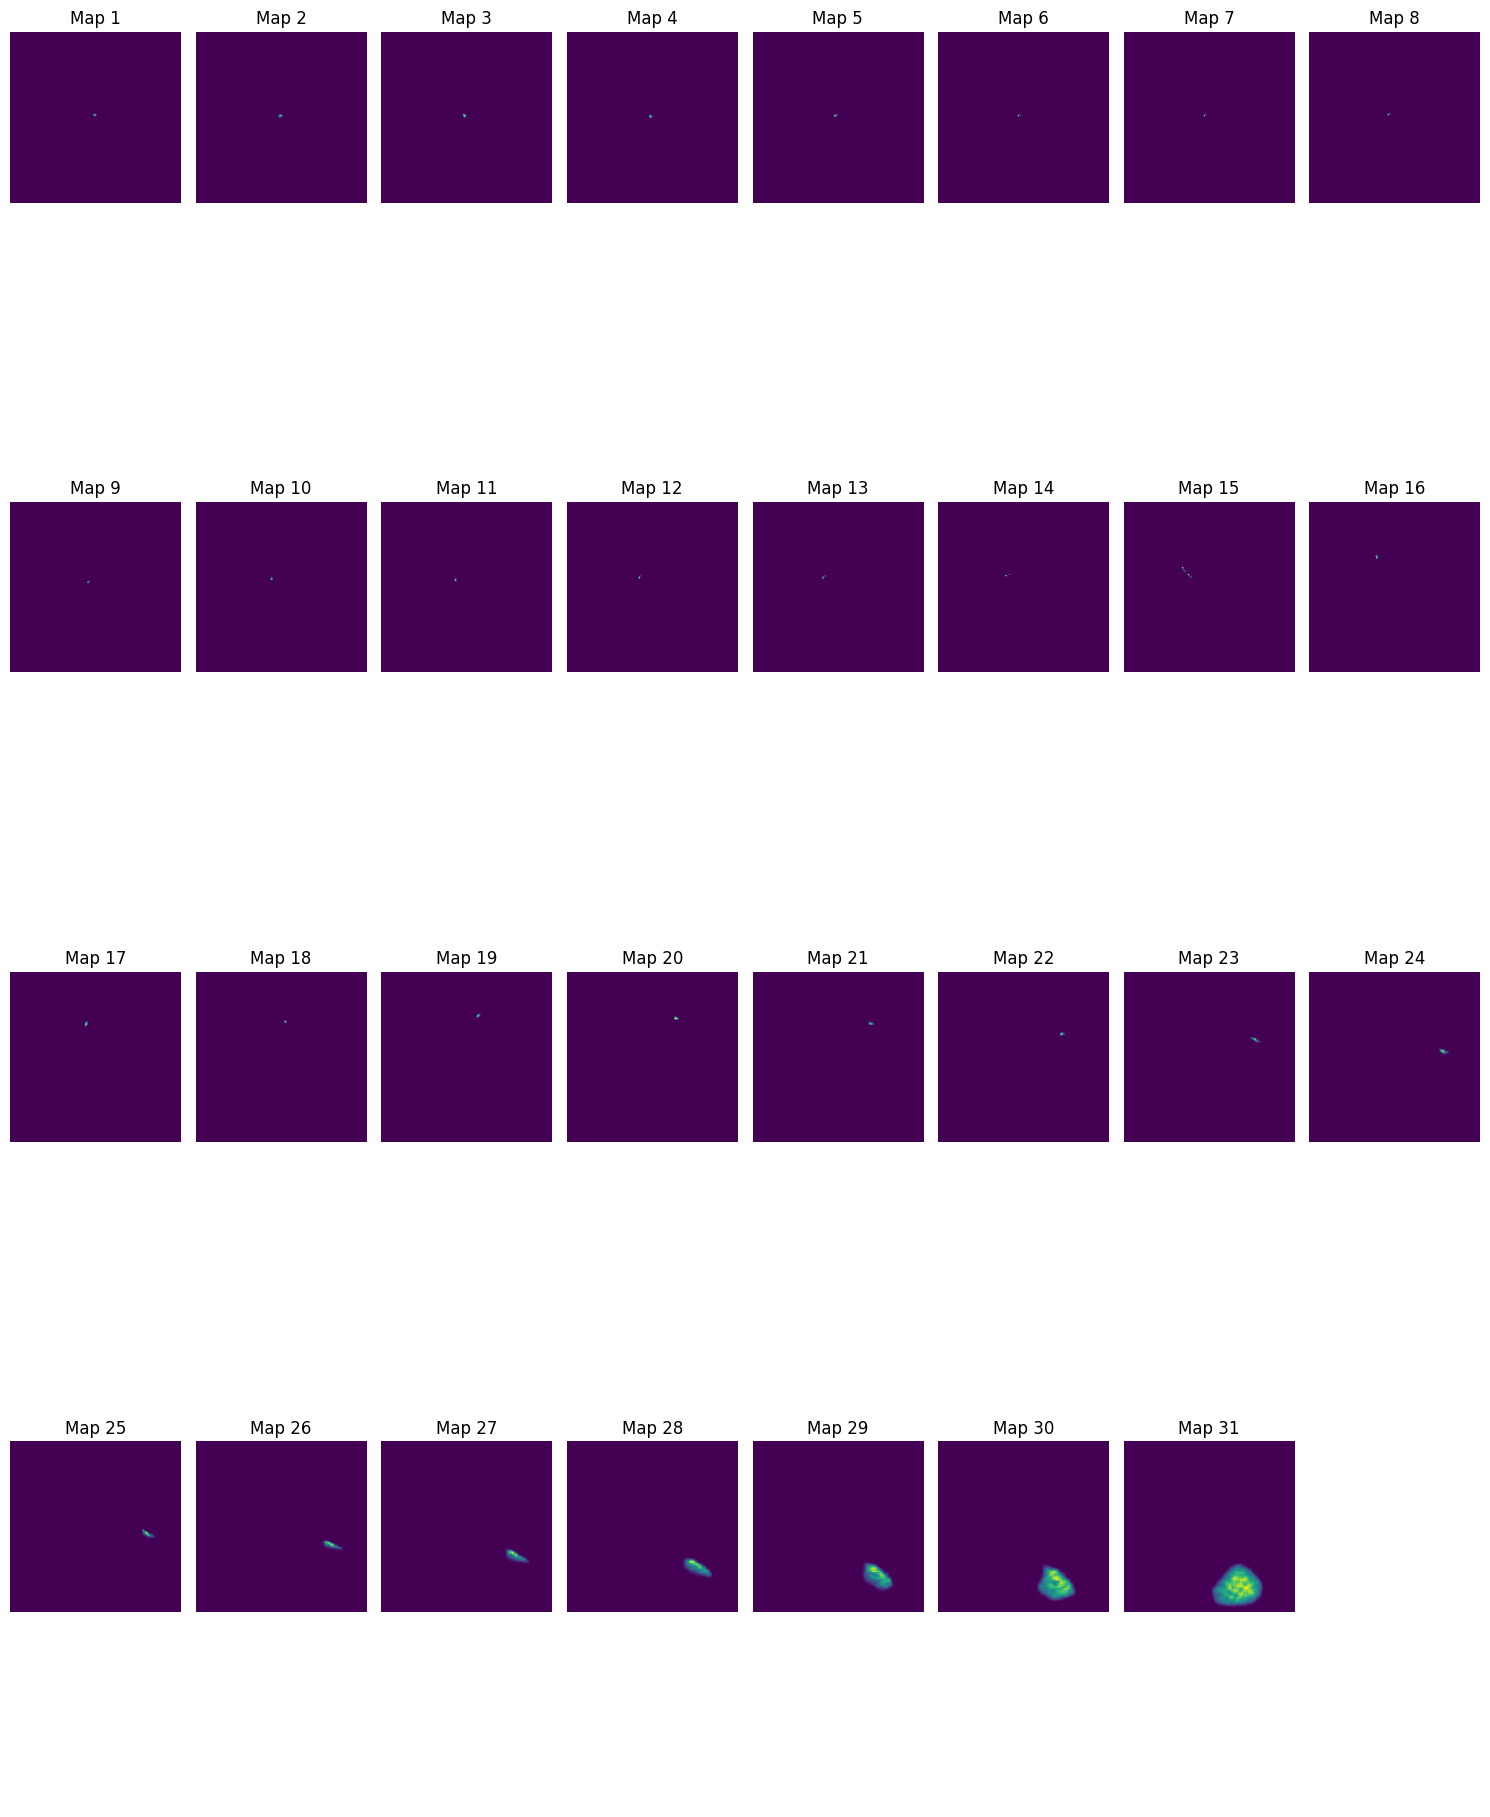

In [18]:
# Assuming summed_chains is the list of maps you want to display
num_maps = len(summed_chains)
rows = 4
cols = (num_maps + rows - 1) // rows  # Calculate number of columns needed


fig, axes = plot.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed


for i, map in enumerate(summed_chains):
   row = i // cols
   col = i % cols
   ax = axes[row, col]
   ax.imshow(map)
   ax.set_title(f'Map {i+1}')  # Set label for each subplot
   ax.axis('off')  # Turn off axis if not needed


# Turn off any remaining empty subplots
for j in range(i + 1, rows * cols):
   row = j // cols
   col = j % cols
   axes[row, col].axis('off')


plot.tight_layout()
plot.show()

In [20]:

predictions = summed_chains


viewer.add_image(
   np.array(predictions),
   colormap='bop orange',
   contrast_limits = None,
   opacity=0.5,
   name='MtM',
   scale=SCALE,
   translate= TRANSLATE,
   visible=True
)


<Image layer 'MtM [1]' at 0x54c8b7e60>

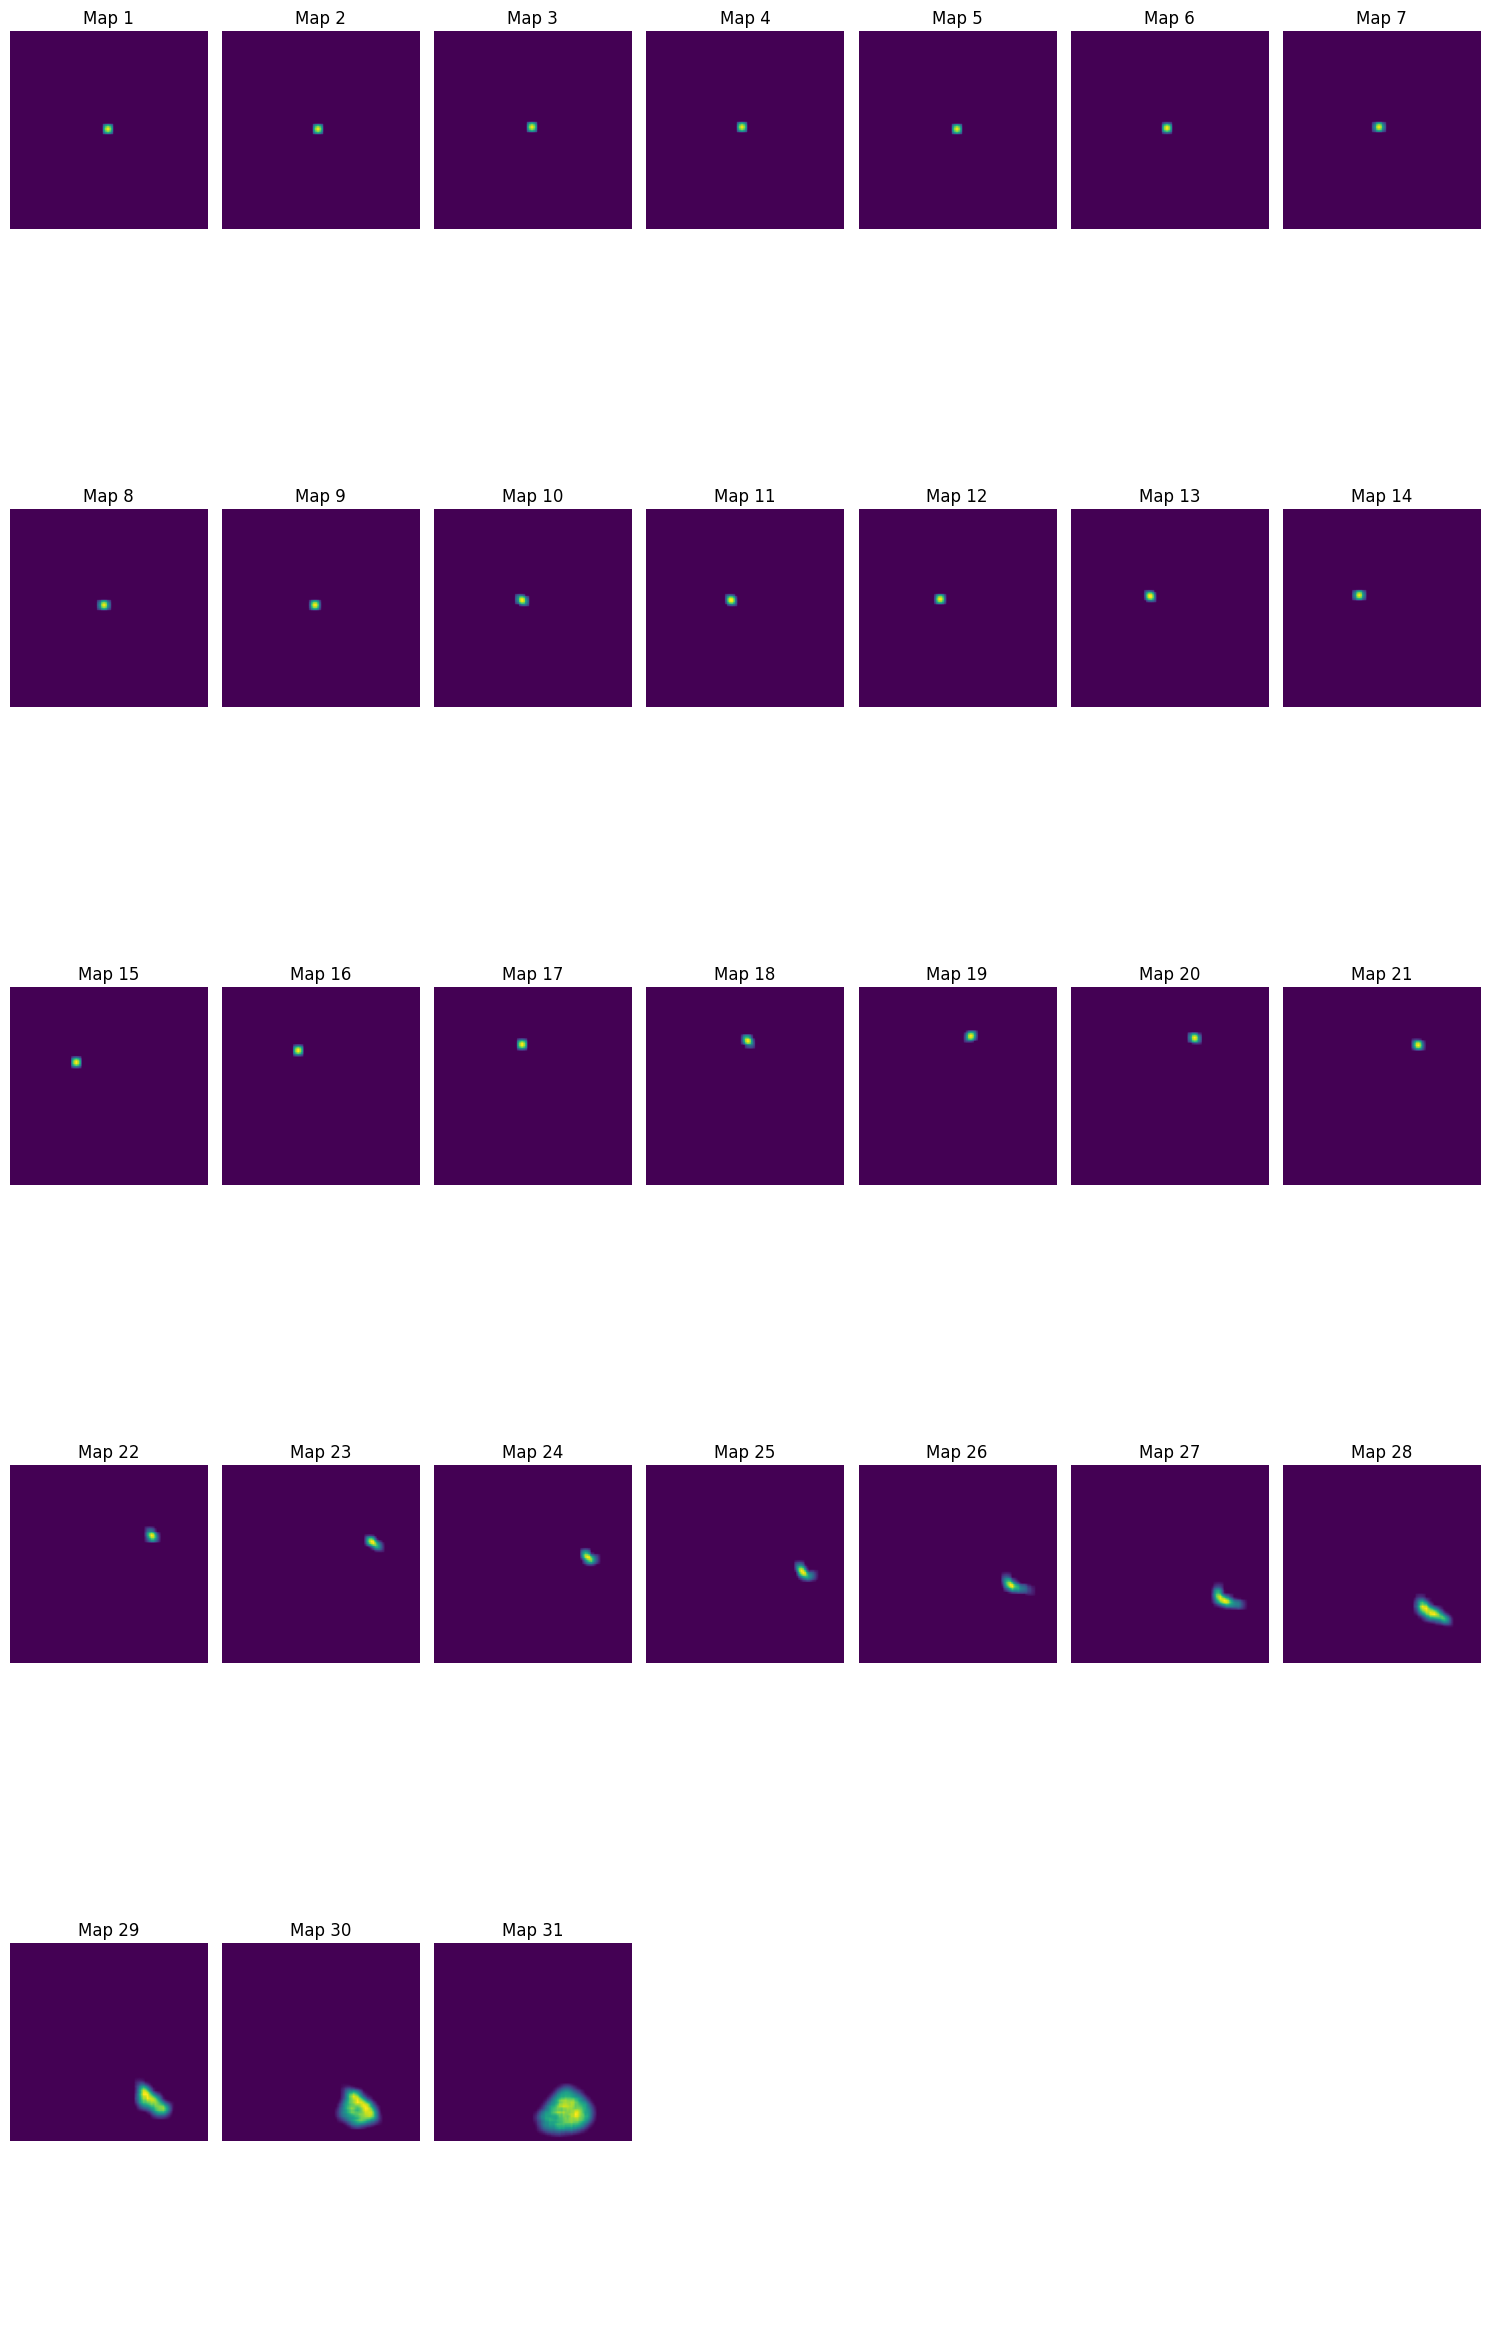

In [24]:
gt_set = []


for time in translated_df["t_ind"].unique():
   this_time = translated_df[(translated_df["t_ind"] == time) & (translated_df["ground_truth"] > 0)]
   coords = this_time[['x', 'y']].values
   gt_set.append(coords)


gt_maps = []


for set in gt_set:
   gt_map = np.zeros((MAP_DIM, MAP_DIM))
   cell_coords = np.int64(set)
   n_cells = cell_coords.shape[0]
   prop = np.ones(n_cells)  # just cell density


   # Populate the map with cell densities
   for idx in range(n_cells):
       gt_map[cell_coords[idx, 1], cell_coords[idx, 0]] += prop[idx]


   sigma_pix = 1
   gt_map = skimage.filters.gaussian(gt_map, sigma=SIGMA_PIX, truncate=1)


   gt_maps.append(gt_map)


num_maps = len(gt_maps)
rows = 5
cols = (num_maps + rows - 1) // rows  # Calculate number of columns needed


fig, axes = plot.subplots(rows, cols, figsize=(15, 5 * rows))  # Adjust figsize as needed


for i, map in enumerate(gt_maps):
   row = i // cols
   col = i % cols
   ax = axes[row, col]
   ax.imshow(map)
   ax.set_title(f'Map {i+1}')  # Set label for each subplot
   ax.axis('off')  # Turn off axis if not needed


# Turn off any remaining empty subplots
for j in range(i + 1, rows * cols):
   row = j // cols
   col = j % cols
   axes[row, col].axis('off')


plot.tight_layout()
plot.show()


In [25]:
viewer.add_image(
   np.array(gt_maps),
   colormap='bop purple',
   contrast_limits = None,
   opacity=0.5,
   name='GT MAP',
   scale=SCALE,
   translate=TRANSLATE,
   visible=True
)

<Image layer 'GT MAP' at 0x3156a6570>

In [26]:
import numpy as np

# Example gt_maps and predictions (replace these with your actual data)

# Ensure both lists have the same length
if len(gt_maps) != len(predictions):
    raise ValueError("The length of gt_maps and predictions must be the same.")

# Compute the difference between corresponding heat maps
differences = [pred - gt for gt, pred in zip(gt_maps, predictions)]


In [21]:
total_diffs = []


for i in range(len(differences)):
    total_diffs.append(sum(sum(differences[i]))**2/sum(sum(gt_maps[i]))**2)

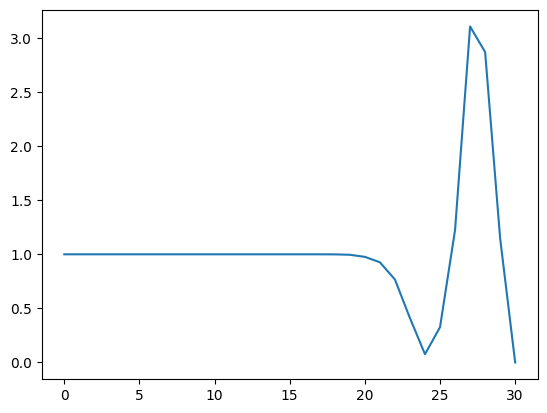

In [22]:
plot.plot(times, total_diffs)

In [23]:
import scipy
pearson_score = []
gens_back = []
for i in range(len(summed_chains)):
    a = gt_maps[-1-i].flatten()
    b = summed_chains[-1-i].flatten()
    gens_back.append(len(summed_chains)-i)
    pearson_score.append(scipy.stats.pearsonr(a, b))

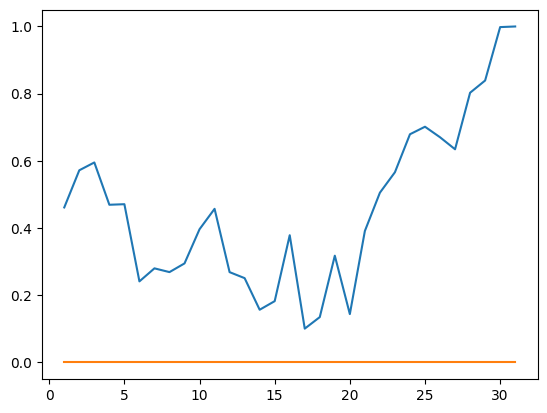

In [24]:
plot.plot(gens_back, pearson_score)